In [13]:
using PyPlot, LinearAlgebra, ImageFiltering, JLD2, MATLAB, MAT

include("code/acoustic_solver.jl")
include("code/acoustic_solver_parallel.jl")
include("code/adjoint_method_new.jl")
include("code/Gauss_Newton_TV.jl")
include("code/TV_projection.jl")
include("code/TV_function.jl")

grad_tv (generic function with 1 method)

In [142]:
# load data
file = matopen("marmousi_data/marmousi_vp10.mat")
vp10 = read(file, "marmousi_vp10") # note that this does NOT introduce a variable ``varname`` into scope
close(file)

Nx = 101
Ny = 101
h = 10*1e-3 * 2

# c_true = vp10[31:31+Nx-1,780:780+Ny-1]
c_true = vp10[11:2:11+2Nx-1,800:2:800+2Ny-1]
# c_true = ones(Nx, Ny)
# c_true[30:45,30:45] .= 1.2
# c_true[30:35,:] .= 1.1
# c_true[50:60,:] .= 1.15

# c_cut = ones(Nx, Ny)

# gaussian filter to generate the initial model
c = imfilter(c_true, Kernel.gaussian(5));
c = (c .- minimum(c)) ./ (maximum(c)-minimum(c)) * (maximum(c_true)-minimum(c_true)) .+ minimum(c_true);
c[1:18, :] .= 1.5
rho = ones(Nx,Ny);
# rho[40:60,30:40] .= 1.5

delta_c = c_true - c;

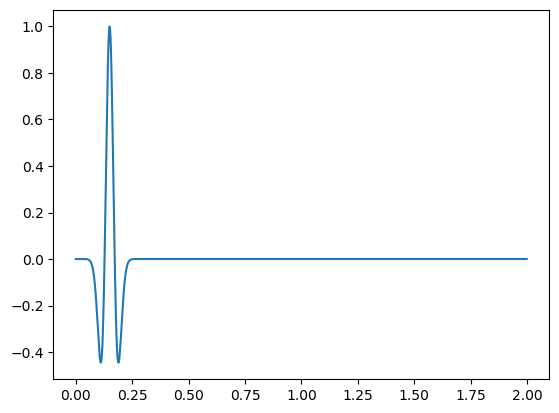

CFL: 0.4449999809265137


In [143]:
# setup coef
Nt = 1000
Fs = 500
dt = 1 / Fs
t = range(0, step=dt, length=Nt)
println("CFL: ", maximum(c_true) * dt / h);

# source
source = source_ricker(10,0.15,t)
source_num = 6
source_position = zeros(Int,source_num,2)
for i = 1:source_num
    source_position[i,:] = [5 1+20(i-1)]
end
source = repeat(source, 1, 1);

# receiver
receiver_num = 51
receiver_position = zeros(Int,receiver_num,2)
for i = 1:51
    receiver_position[i,:] = [1, (i-1)*2+1]
end
# for i = 52:101
#     receiver_position[i,:] = [61, (i-51)*2+1]
# end
# for i = 102:131
#     receiver_position[i,:] = [(i-102)*2+1, 1]
# end
# for i = 132:161
#     receiver_position[i,:] = [(i-132)*2+1, 101]
# end

# PML
pml_len = 30
pml_coef = 50;

plot(t,source);

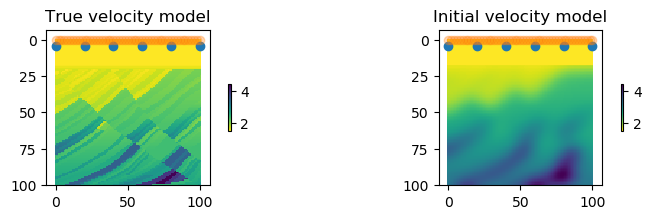

In [144]:
# plot model
figure(figsize=(8,4))

subplot(221)
imshow(c_true, cmap="viridis_r"); title("True velocity model"); colorbar(shrink=0.3)
scatter(source_position[:,2].-1, source_position[:,1].-1)
scatter(receiver_position[:,2].-1, receiver_position[:,1].-1, alpha=0.3)

subplot(222)
imshow(c, cmap="viridis_r"); title("Initial velocity model"); colorbar(shrink=0.3)
scatter(source_position[:,2].-1, source_position[:,1].-1)
scatter(receiver_position[:,2].-1, receiver_position[:,1].-1, alpha=0.3)

tight_layout()

In [145]:
@time received_data = multi_solver_no_wavefield(c_true, rho, Nx, h, Ny, h, Nt, dt, source, source_position, receiver_position; pml_len=pml_len, pml_coef=pml_coef);


  3.223500 seconds (493.57 k allocations: 46.947 MiB)


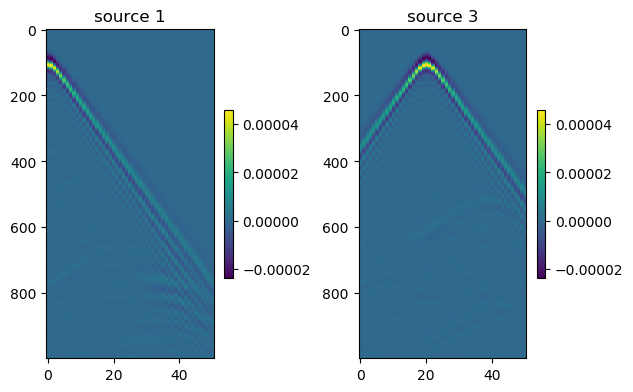

In [146]:

subplot(121)
source_ind = 1
imshow(received_data[:,:,source_ind], aspect=0.1); title("source 1"); colorbar(shrink=0.4)
subplot(122)
source_ind = 3
imshow(received_data[:,:,source_ind], aspect=0.1); title("source 3"); colorbar(shrink=0.4)
tight_layout()

In [147]:
# function handle
TV_lambda = 1e-17
TV_iterMax = 3000
CG_tol = 0.2
CG_iterMax = 15

# eval_fn(x) = compute_obj_fn(received_data, x, rho, Nx, h, Ny, h, Nt, dt, source, source_position, receiver_position; pml_len=pml_len, pml_coef=pml_coef)

eval_tv_fn(x, x0) = compute_obj_TV_fn(received_data, x, x0, TV_lambda, rho, Nx, h, Ny, h, Nt, dt, source, source_position, receiver_position; pml_len=pml_len, pml_coef=pml_coef)

eval_grad(x) = compute_grad(received_data, x, rho, Nx, h, Ny, h, Nt, dt, source, source_position, receiver_position; pml_len=pml_len, pml_coef=pml_coef)

eval_CG_step(x) = compute_CG_step(received_data, x, rho, Nx, h, Ny, h, Nt, dt, source, source_position, receiver_position; CG_tol=CG_tol, CG_iterMax=CG_iterMax, pml_len=pml_len, pml_coef=pml_coef);

eval_CG_TV_step(x) = compute_CG_TV_step(received_data, x, rho, Nx, h, Ny, h, Nt, dt, source, source_position, receiver_position; CG_tol=CG_tol, CG_iterMax=CG_iterMax, TV_lambda=TV_lambda, TV_iterMax=TV_iterMax, pml_len=pml_len, pml_coef=pml_coef);



In [148]:
gg = eval_grad(c);
fk1, gg_gn = eval_CG_step(c);

    Start CG iteration. ||grad f|| = 1.35478e-10, tol = 2.70957e-11
    iteration: 1, ||r1|| = 1.61399e-10
    iteration: 2, ||r1|| = 7.95501e-11
    iteration: 3, ||r1|| = 6.23162e-11
    iteration: 4, ||r1|| = 5.21650e-11
    iteration: 5, ||r1|| = 5.12592e-11
    iteration: 6, ||r1|| = 4.73083e-11
    iteration: 7, ||r1|| = 4.12789e-11
    iteration: 8, ||r1|| = 3.71709e-11
    iteration: 9, ||r1|| = 3.53676e-11
    iteration: 10, ||r1|| = 3.10319e-11
    iteration: 11, ||r1|| = 2.45721e-11 < tol, break
    CG iteration done.


In [149]:
fk2, gg_tv = eval_CG_TV_step(c);

    TV projection: TV_lambda = 1.00000e-17
    Start CG iteration. ||grad f|| = 1.35478e-10, tol = 2.70956e-11
    iteration: 1, ||r1|| = 1.61398e-10
    iteration: 2, ||r1|| = 7.95498e-11
    iteration: 3, ||r1|| = 6.23159e-11
    iteration: 4, ||r1|| = 5.21646e-11
    iteration: 5, ||r1|| = 5.12588e-11
    iteration: 6, ||r1|| = 4.73078e-11
    iteration: 7, ||r1|| = 4.12784e-11
    iteration: 8, ||r1|| = 3.71703e-11
    iteration: 9, ||r1|| = 3.53669e-11
    iteration: 10, ||r1|| = 3.10313e-11
    iteration: 11, ||r1|| = 2.45715e-11 < tol, break
    CG iteration done.


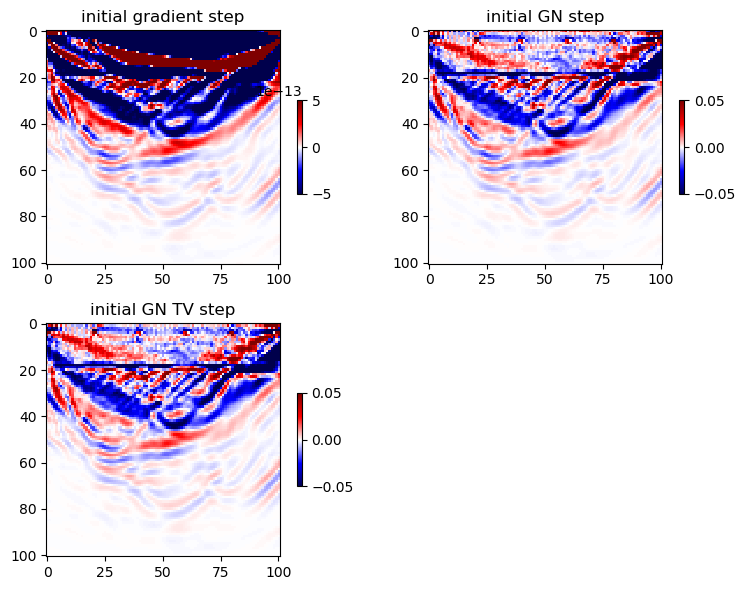

In [151]:
figure(figsize=(8,6))
subplot(221)
va = 5e-13
imshow(reshape(-gg, Nx, Ny), cmap="seismic"); colorbar(shrink=0.4); clim(-va, va); title("initial gradient step")
va = 5e-2
subplot(222)
imshow(reshape(gg_gn, Nx, Ny), cmap="seismic"); colorbar(shrink=0.4); clim(-va, va); title("initial GN step")
subplot(223)
imshow(reshape(gg_tv, Nx, Ny), cmap="seismic"); colorbar(shrink=0.4); clim(-va, va); title("initial GN TV step")

tight_layout()

In [140]:
x0 = copy(c)
iterNum = 3
min_value = minimum(c_true)
max_value = maximum(c_true)

xk, fk = Gauss_Newton(eval_tv_fn, eval_CG_TV_step, x0, iterNum, min_value, max_value; alpha=1, rho=0.5, c=1e-20, maxSearchTime=5, threshold=1e-12);





----------------------------------------------------------------
Start Gauss Newton method:
----------------------------------------------------------------
    TV projection: TV_lambda = 1.00000e-17
    Start CG iteration. ||grad f|| = 1.89305e-10, tol = 3.78610e-11
    iteration: 1, ||r1|| = 2.48451e-10
    iteration: 2, ||r1|| = 1.09263e-10
    iteration: 3, ||r1|| = 8.28233e-11
    iteration: 4, ||r1|| = 7.66542e-11
    iteration: 5, ||r1|| = 6.60927e-11
    iteration: 6, ||r1|| = 5.10227e-11
    iteration: 7, ||r1|| = 4.88782e-11
    iteration: 8, ||r1|| = 4.24745e-11
    iteration: 9, ||r1|| = 4.80158e-11
    iteration: 10, ||r1|| = 3.83381e-11
    iteration: 11, ||r1|| = 3.02969e-11 < tol, break
    CG iteration done.
----------------------------------------------------------------
Main iteration: 1
Start line search. fk: 1.08796e-07
    alpha: 1.00000e+00    fk1: 2.07059e-07    fk-c*alpha*gradk^2: 1.08796e-07
    alpha: 5.00000e-01    fk1: 1.30757e-07    fk-c*alpha*gradk^2: 1.0

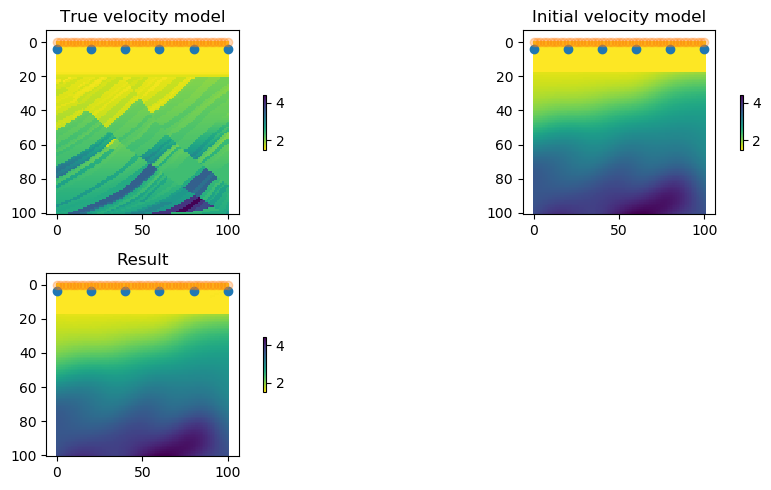

In [141]:
# plot model
ma = maximum(c_true)
mi = minimum(c_true)
figure(figsize=(10,5))

subplot(221)
imshow(c_true, cmap="viridis_r"); title("True velocity model"); colorbar(shrink=0.3)
scatter(source_position[:,2].-1, source_position[:,1].-1)
scatter(receiver_position[:,2].-1, receiver_position[:,1].-1, alpha=0.3)

subplot(222)
imshow(c, cmap="viridis_r"); title("Initial velocity model"); colorbar(shrink=0.3)
scatter(source_position[:,2].-1, source_position[:,1].-1)
scatter(receiver_position[:,2].-1, receiver_position[:,1].-1, alpha=0.3)

subplot(223)
imshow(reshape(xk,Nx,Ny), cmap="viridis_r"); title("Result"); colorbar(shrink=0.3); clim(mi, ma)
scatter(source_position[:,2].-1, source_position[:,1].-1)
scatter(receiver_position[:,2].-1, receiver_position[:,1].-1, alpha=0.3)

tight_layout()

In [48]:
# @save "data_tv_8e-16.jld2" xk